In [1]:
%pylab notebook

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from svgpathtools import svg2paths, wsvg
from numpy import *
from fonts.font_helpers import print_table

In [3]:
paths, attributes = svg2paths('numbers.svg')
[a["id"] for a in attributes]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'colon']

In [4]:
paths[0]

Path(Line(start=(1.3264904+1.3143095j), end=(4.2130706+1.3143095j)),
     Line(start=(4.2130706+1.3143095j), end=(4.2130706+3.7461725j)),
     Line(start=(4.2130706+3.7461725j), end=(1.3270094+3.7461725j)),
     Line(start=(1.3270094+3.7461725j), end=(1.3264904+1.3143095j)),
     Line(start=(0.13231434+0.1507195j), end=(5.4035085+0.1507195j)),
     Line(start=(5.4035085+0.1507195j), end=(5.4035085+4.7558882j)),
     Line(start=(5.4035085+4.7558882j), end=(0.13310934+4.7558882j)),
     Line(start=(0.13310934+4.7558882j), end=(0.13231434+0.1507195j)))

In [5]:
def getVecs(ps):
    # returns array of vertices with real / imaginary parts for x, y
    # edges as indices into the vertex array in drawing order. 
    # If bit 0x8000 is set, do a goto, if not draw a line
    a = set()
       
    for p in ps:
        a.add(p.start)
        a.add(p.end)
    a = array(list(a))
    
    lineInds = zeros((len(ps), 2), dtype=int)
    for i, p in enumerate(ps):
        lineInds[i, 0] = where(abs(a - p.start) == 0)[0][0]
        lineInds[i, 1] = where(abs(a - p.end) == 0)[0][0]
    
    lineInds = []
    last_point = None
    for p in ps:
        if last_point is None or p.start != last_point:
            # goto start point
            start_ind = where(abs(a - p.start) == 0)[0][0]
            lineInds.append(0x8000 | start_ind)
        
        # line to end point
        end_ind = where(abs(a - p.end) == 0)[0][0]
        lineInds.append(end_ind)
        
        last_point = p.end
    
#     a -= ps[0].start
    a -= mean(a)
    return a, array(lineInds)

getVecs(paths[0])

(array([-2.63669587-2.34105293j, -1.44251981-1.17746293j,
         2.63449829-2.34105293j,  1.44406039-1.17746293j,
        -1.44200081+1.25440007j, -2.63590087+2.26411578j,
         1.44406039+1.25440007j,  2.63449829+2.26411578j]),
 array([32769,     3,     6,     4,     1, 32768,     2,     7,     5,
            0]))

In [6]:
def extrude(vs, ls, depth=3):
    n_vs = vs.shape[0]
    vs_ = zeros((n_vs * 2, 3), dtype=float)

    # bottom side at z = 0
    vs_[:n_vs, 0] = real(vs)
    vs_[:n_vs, 1] = imag(vs)
    vs_[:n_vs, 2] = -depth / 2

    # offset top side at z = depth
    vs_[n_vs:, 0] = real(vs)
    vs_[n_vs:, 1] = imag(vs)
    vs_[n_vs:, 2] = depth / 2

    # add edges
    n_ls = ls.shape[0]
    ls_ = zeros((n_ls * 2 + n_vs * 2), dtype=int)
    # edges bottom side
    ls_[:n_ls] = ls
    # edges top side
    ls_[n_ls: n_ls * 2] = ls + n_vs
    # connect them
    ls_[n_ls * 2:][0::2] = arange(n_vs) | 0x8000
    ls_[n_ls * 2:][1::2] = arange(n_vs) + n_vs
    return vs_, ls_

In [7]:
extrude(*getVecs(paths[0]))

(array([[-2.63669587, -2.34105293, -1.5       ],
        [-1.44251981, -1.17746293, -1.5       ],
        [ 2.63449829, -2.34105293, -1.5       ],
        [ 1.44406039, -1.17746293, -1.5       ],
        [-1.44200081,  1.25440007, -1.5       ],
        [-2.63590087,  2.26411578, -1.5       ],
        [ 1.44406039,  1.25440007, -1.5       ],
        [ 2.63449829,  2.26411578, -1.5       ],
        [-2.63669587, -2.34105293,  1.5       ],
        [-1.44251981, -1.17746293,  1.5       ],
        [ 2.63449829, -2.34105293,  1.5       ],
        [ 1.44406039, -1.17746293,  1.5       ],
        [-1.44200081,  1.25440007,  1.5       ],
        [-2.63590087,  2.26411578,  1.5       ],
        [ 1.44406039,  1.25440007,  1.5       ],
        [ 2.63449829,  2.26411578,  1.5       ]]),
 array([32769,     3,     6,     4,     1, 32768,     2,     7,     5,
            0, 32777,    11,    14,    12,     9, 32776,    10,    15,
           13,     8, 32768,     8, 32769,     9, 32770,    10, 32771,
 

In [13]:
verts = list()
edgs = list()
verts_end = list()
edgs_end = list()

for ps in paths:
    v, e = extrude(*getVecs(ps), depth=2)
    
    v[:, 1] *= -1
#     format is 16 bit int with 12 bit fractional part
    v = (v * 0x1000).astype(int).flatten()
    print(v[:3])
        
    verts.extend(v)
    verts_end.append(len(verts))
    
    edgs.extend(e)
    edgs_end.append(len(edgs))
    
#     lv = v.shape[0]
#     le = e.shape[0]
#     lvs.append(lv)
#     les.append(le)
#     edgs.append(e)

[-10799   9588  -4096]
[-2405 -9443 -4096]
[-13653   9451  -4096]
[-7812 -2450 -4096]
[ 4329 -5555 -4096]
[ 2338  4587 -4096]
[-8547  9612 -4096]
[-8222  7879 -4096]
[-9493  9441 -4096]
[-11969   9424  -4096]
[-2505 -5169 -4096]


<IPython.core.display.Javascript object>


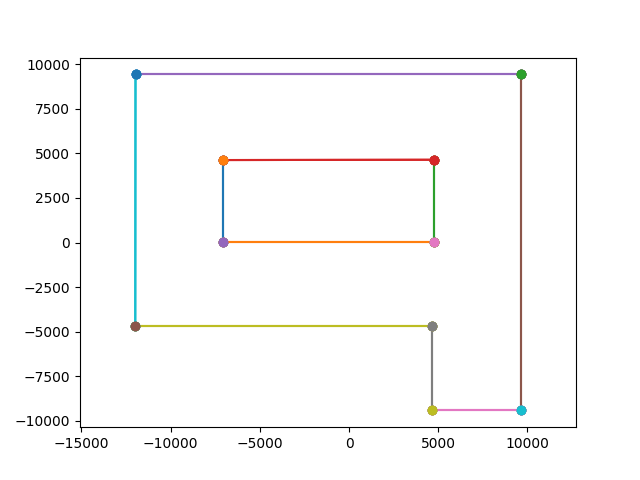

(-13062.15, 10701.15, -10348.55, 10365.55)

In [14]:
plot_id = 9

if plot_id > 0:
    vs = verts[verts_end[plot_id - 1]: verts_end[plot_id]]
else:
    vs = verts[0: verts_end[plot_id]]
vs = array(vs).reshape(-1, 3)

if plot_id > 0:
    es = edgs[edgs_end[plot_id - 1]: edgs_end[plot_id]]
else:
    es = edgs[0: edgs_end[plot_id]]
    
es = array(es)


# Plot the data, but need to unpack it first
close()
start_p = None
for e in es:
    if e >= 0x8000:
        start_p = e & 0x7FFF
        continue
        
    v_a = vs[start_p]
    v_b = vs[e]
    plot([v_a[0], v_b[0]], [v_a[1], v_b[1]], '-o')   
    
    start_p = e
    
axis('equal')

# C code generation

In [15]:
def print_table2(vals, prefix='static const int all_vertices', **kwargs):
    print(f'{prefix}[{len(vals)}] = {{', file=kwargs.get("f"))
    print_table(vals, **kwargs)

In [18]:
with open('../src/fonts/wf_numbers.c', 'w') as f:
    print('''\
#include <stdint.h>
#include <stdio.h>
#include <wireframe_draw.h>

// -----------------------------------
//  3D objects: digits 0-9 and a colon
// -----------------------------------
    ''', file=f)
    print_table2(verts, prefix='static const int16_t all_vertices', w=8, w_v=7, f=f)
    print_table2(edgs, prefix='static const uint16_t all_edges', w=8, w_v=7, f=f)
    print_table2(verts_end, prefix='static const uint16_t vertices_ends', w=8, w_v=7, f=f)
    print_table2(edgs_end, prefix='static const uint16_t edges_ends', w=8, w_v=7, f=f)

    print(f'''\
const edges_3d_t wf_numbers = {{
    .n_objects = {len(edgs_end)},
    .all_vertices = all_vertices,
    .all_edges = all_edges,
    .vertices_ends = vertices_ends,
    .edges_ends = edges_ends
}};
    ''', file=f)

print('wrote', f.name)

wrote ../src/fonts/wf_numbers.c


In [19]:
!cat ../src/fonts/wf_numbers.c

#include <stdint.h>
#include <stdio.h>
#include <wireframe_draw.h>

// -----------------------------------
//  3D objects: digits 0-9 and a colon
// -----------------------------------
    
static const int16_t all_vertices[576] = {
 -10799,   9588,  -4096,  -5908,   4822,  -4096,  10790,   9588,
  -4096,   5914,   4822,  -4096,  -5906,  -5138,  -4096, -10796,
  -9273,  -4096,   5914,  -5138,  -4096,  10790,  -9273,  -4096,
 -10799,   9588,   4096,  -5908,   4822,   4096,  10790,   9588,
   4096,   5914,   4822,   4096,  -5906,  -5138,   4096, -10796,
  -9273,   4096,   5914,  -5138,   4096,  10790,  -9273,   4096,
  -2405,  -9443,  -4096,   2423,  -9443,  -4096,  -2441,   9443,
  -4096,   2423,   9443,  -4096,  -2405,  -9443,   4096,   2423,
  -9443,   4096,  -2441,   9443,   4096,   2423,   9443,   4096,
 -13653,   9451,  -4096, -13670,   4671,  -4096,   2493,   9419,
  -4096,  -2394,   4671,  -4096,   2493,  -4594,  -4096,  -2394,
  -9512,  -4096,  13562,  -4594,  -4096,  13562,  -9